In [2]:
%matplotlib widget
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")

import morph_geom_lib as mgl
import models.shallow_depth_morph_models as sdmodels
import schemes.avalanche_scheme 


from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

import schemes.weno as weno
import sediment_transport.sed_trans as sedtrans
from schemes.avalanche_scheme import avalanche_model, get_slope
from models.shallow_water_solver import shallow_water_solver

rc('animation', html='html5')

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


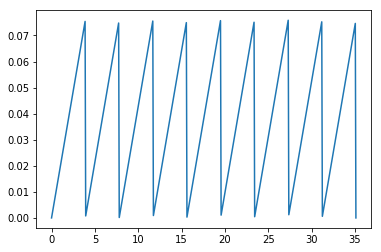

In [6]:
dunes = 9

xsaw = np.linspace(0, 1,500)
simTime = 60*10 # Runtime in seconds
dt = 0.5 # Time step size (s)

#zsaw = 0.076*(signal.sawtooth(2*dunes*np.pi * xsaw) + 1.)/2
xsaw = xsaw*7.8*dunes*0.5

plt.plot(xsaw, zsaw)

In [40]:

surface = 0.237
intial_flow = 0.0789

def inlet_BC(state,dim,t,qbc,auxbc,num_ghost):
    qIn = state.problem_data['lower_bc_data']
    qbc[0, :num_ghost] = qbc[0, num_ghost]
    qbc[1,:num_ghost] = qIn
    
    
def outlet_BC(state,dim,t,qbc,auxbc,num_ghost):
    sOut = state.problem_data['upper_bc_data']
    n = len(state.grid.x.centers)
    hOut = sOut - state.aux[0, n-1]
    # print(sOut, hOut, qbc[0, -num_ghost:] )
    qbc[0, -num_ghost:] = hOut
    qbc[1, -num_ghost:] = qbc[1, -num_ghost - 1]

def source_chezy(solver,state,dt):
    
    kappa = 0.4
    Bs = 8.5
    b = 0.76
    Slope = state.problem_data['slope']
    ks = state.problem_data['ks']
    g = state.problem_data['grav']
    q = state.q
     
    # From eq. 1.14 in Yalin and da Silva
    cf = ((1./kappa)*np.log(0.368*q[0,:]/ks) + Bs)   
    
    # Based on eq. 1.16 and solving for S. (mulitply by h first)
    Sf = q[1,:]*np.abs(q[1,:])/(g*(cf**2.)*q[0,:]**(3.))
    
    q[1,:] = q[1,:] + q[0,:]*g*(Slope - Sf)*dt

solver = pyclaw.ClawSolver1D(riemann.shallow_bathymetry_fwave_1D)
solver.limiters = pyclaw.limiters.tvd.minmod
solver.fwave = True
solver.num_waves = 2
solver.num_eqn = 2        
solver.max_steps = 100000
solver.source_split = 1
solver.order = 2


x = pyclaw.Dimension(0.0,xsaw.max(),len(xsaw),name='x')
domain = pyclaw.Domain(x)
state = pyclaw.State(domain, 2, 1)

xc = state.grid.x.centers
dx = state.grid.delta[0]      

# Specify the bathymetry
state.aux[0, :] = zsaw

# Gravitational constant
state.problem_data['grav'] = 9.8
state.problem_data['dry_tolerance'] = 1.e-3
state.problem_data['sea_level'] = 0.0

# Set the source term:
solver.step_source = source_chezy
state.problem_data['ks'] = 0.0033
state.problem_data['slope'] = 1/726.


# Set the starting water depth (h)
state.q[0, :] = surface - state.aux[0, :]

# Set the intial flow         
state.q[1, :] = intial_flow


# Setup the Boundary conditions
solver.bc_lower[0] = pyclaw.BC.custom
solver.bc_upper[0] = pyclaw.BC.custom

state.problem_data['lower_bc_data'] = intial_flow
state.problem_data['upper_bc_data'] = surface

solver.user_bc_lower = inlet_BC
solver.user_bc_upper = outlet_BC

solver.aux_bc_lower[0] = pyclaw.BC.extrap
solver.aux_bc_upper[0] = pyclaw.BC.extrap



# Setup the controller
controller = pyclaw.Controller()
controller.keep_copy = True
controller.tfinal = 1000
controller.solution = pyclaw.Solution(state, domain)
controller.solver = solver
controller.write_aux_init = True
controller.num_output_times = 10

controller.run()

h = controller.frames[controller.num_output_times].q[0,:]
u = controller.frames[controller.num_output_times].q[1,:]



2019-05-21 03:39:23,711 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-21 03:39:24,408 INFO CLAW: Solution 1 computed for time t=100.000000
2019-05-21 03:39:25,269 INFO CLAW: Solution 2 computed for time t=200.000000
2019-05-21 03:39:25,977 INFO CLAW: Solution 3 computed for time t=300.000000
2019-05-21 03:39:26,738 INFO CLAW: Solution 4 computed for time t=400.000000
2019-05-21 03:39:27,402 INFO CLAW: Solution 5 computed for time t=500.000000
2019-05-21 03:39:28,047 INFO CLAW: Solution 6 computed for time t=600.000000
2019-05-21 03:39:28,703 INFO CLAW: Solution 7 computed for time t=700.000000
2019-05-21 03:39:29,451 INFO CLAW: Solution 8 computed for time t=800.000000
2019-05-21 03:39:30,099 INFO CLAW: Solution 9 computed for time t=900.000000
2019-05-21 03:39:30,766 INFO CLAW: Solution 10 computed for time t=1000.000000


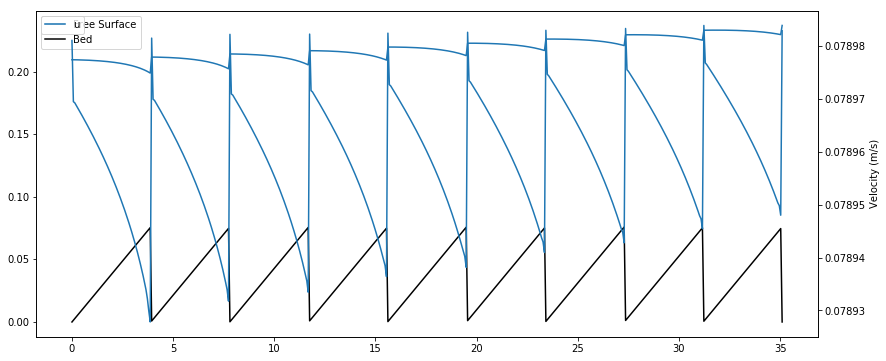

In [42]:


surf = h + zsaw


fig,ax1 = plt.subplots(figsize=(14, 6))
plt.plot(xsaw, surf, label = 'Free Surface')
plt.plot(xsaw, zsaw, color='k', label = 'Bed')
plt.legend()
ax2 = ax1.twinx() 
ax2.plot(xsaw, u, label='u')
ax2.set_ylabel('Velocity (m/s)')

plt.legend()